# Let's do it, let's train a Noise Model!

**You are new to Jupyter notebooks?** Don't worry, if you take the time to read all our explanations, we will guide you through them and you will understand a lot. Still, you will likely end up less frustrated, if you do not even start with the ambition to interpret the purpose of every line of code.
Let's start with a nice example, the imports to enable the remainder of this notebook. Ignore it (unless you know what you are doing) and just click **⇧*Shift* + ⏎*Enter*** to execute this (and all other) code cells. 

In [1]:
# importing all the things we need further down
import platform
from pathlib import Path

import pooch
import numpy as np
import matplotlib.pyplot as plt

from careamics import CAREamist
from careamics.models.lvae.noise_models import (
    GaussianMixtureNoiseModel,
    create_histogram,
)
from careamics.lvae_training.dataset import DataSplitType
from careamics.config import GaussianMixtureNMConfig
from careamics.config import create_n2v_configuration

# Dataset specific imports...
from microsplit_reproducibility.configs.data.custom_dataset_2D import get_data_configs
from microsplit_reproducibility.datasets.custom_dataset_2D import get_train_val_data
from microsplit_reproducibility.utils.utils import plot_probability_distribution

# **Step 0.1:** Data Preparation

### Load example data

In [2]:
# DATA = pooch.create(
#     path=f"./data/",
#     base_url=f"https://download.fht.org/jug/msplit/ht_lif24/data_tiff/",
#     registry={f"ht_lif24_5ms_reduced.zip": None},
# )
# for fname in DATA.registry:
#     DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)

# DATA_PATH = DATA.abspath / (DATA.registry_files[0] + ".unzip/5ms/data/")

### OR set the directory to your own data
Important: the directory path should end with `data/`


In [ ]:
DATA_PATH = Path("/group/jug/aman/Datasets/PAVIA_ATN/")

### Next, we load the image data to be processed

In [4]:
train_data_config, val_data_config, test_data_config = get_data_configs(
    image_size=(64, 64), num_channels=2
)

input_data = get_train_val_data(
    data_config=train_data_config,
    datadir=DATA_PATH,
    datasplit_type=DataSplitType.Train,
    val_fraction=0.1,
    test_fraction=0.1,
)

In [5]:
# We use a subset of the data for training the noise model - here we select this subset...
print(input_data.shape)
train_data = input_data[0:-1:10, :, :, :].squeeze()
print(train_data.shape)

(49, 2720, 2720, 2)
(5, 2720, 2720, 2)


### Show some of the loaded data...

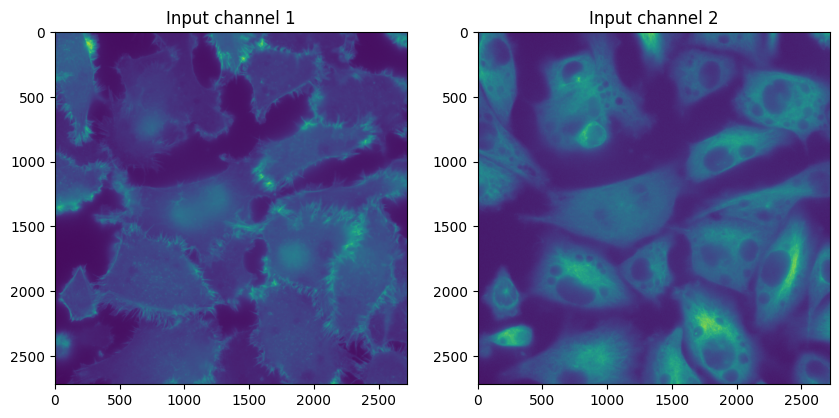

In [6]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_data[0, ..., 0])
ax[0].set_title("Input channel 1")
ax[1].imshow(train_data[0, ..., 1])
ax[1].set_title("Input channel 2")
plt.show()

# **Step 0.2:** Using Noise2Void to generate 'clean' data
You do not have access to the microscope that acquired the data we just downloaded. Hence, as described above, we use a little tick to get the required ground truth data we need to generate a Noise Model -- [Noise2Void (N2V)](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf)!

In a nutshell: we train a N2V model, denoise the data we just downloaded, and then create a Noise Model from the noisy raw data and the predictions from [N2V](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf).

### Configure `num_workers`
In Windows and MacOS, setting `num_workers > 0` for dataloaders would cause out-of-memory issue and might crash the system.

In [7]:
def get_num_workers():
    """Utility function to set num_workers based on OS."""
    if platform.system() == "Windows" or platform.system() == "Darwin":
        return 0
    else:
        return 3  # or any other number suitable for your system

### Configure N2V
Please note that we have set `num_epochs=5`, so you don't have to wait a long time. If you want a serious Noise Model to be trained, you should change this to a higher number!

In [ ]:
config = create_n2v_configuration(
    experiment_name="my_data_noise_models_n2v",
    data_type="array",
    axes="SYXC",
    n_channels=2,
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=5000,  # We set the training to 5 epochs, but you can change this to a higher number if you want a better Noise Model.
    train_dataloader_params={"num_workers": get_num_workers()},
    val_dataloader_params={"num_workers": get_num_workers()},
)

print("N2V configuration generated.")

N2V configuration generated.


### Train N2V on the data we prepared
This might take a while, mainly if you changed `num_epochs` above or if you do not have a quick GPU.

In [10]:
careamist = CAREamist(source=config, work_dir="noise_models")
careamist.train(train_source=train_data, val_minimum_split=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 1.0 M  | train
---------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.074     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Denoise loaded data with the N2V model we just trained

In [11]:
prediction = careamist.predict(train_data, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/conda/envs/msr/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Show denoising results obtained with N2V

In [12]:
# Make your choice. If 'False', the entire image will be shown...
do_crop = True

xfrom = yfrom = 0
xto = yto = -1
strcrop = ""
if do_crop:
    strcrop = " (crop)"
    yfrom = 200
    yto = 600
    xfrom = 800
    xto = 1200

_, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(train_data[0, ..., 0][yfrom:yto, xfrom:xto])
ax[0][0].set_title("Input channel 1" + strcrop)
ax[0][1].imshow(prediction[0].squeeze()[0][yfrom:yto, xfrom:xto])
ax[0][1].set_title("Denoised channel 1" + strcrop)
ax[1][0].imshow(train_data[0, ..., 1][yfrom:yto, xfrom:xto])
ax[1][0].set_title("Input channel 2" + strcrop)
ax[1][1].imshow(prediction[0].squeeze()[1][yfrom:yto, xfrom:xto])
ax[1][1].set_title("Denoised channel 2" + strcrop)
plt.show()

# **Step 0.3:** Train the Noise Model

Finally, here we train a Noise Model using the raw noisy data we downloaded and the denoised images we created with the N2V model we trained. Once done, we will have 'bootstrapped' a Noise Model.

Please note that we need one noise model for each unmixed channel we will later predict with <nobr>Micro$\mathbb{S}$plit</nobr>.

Also note that to obtain the best noise model, we shoud train on all available data for at least 5000 epochs

Training noise model for channel 0
[GaussianMixtureNoiseModel] min_sigma: 200.0
0 11.443302154541016
100 6.409502773284912
200 5.814340400695801
300 5.770378489494323
400 5.758646602630615
500 5.7538491010665895
600 5.751423048973083
700 5.749745268821716
800 5.748652062416077
900 5.747897820472717

The trained parameters (noise_model_Ch0) is saved at location: noise_models/


/home/aman.kukde/Projects_2/MicroSplit-reproducibility/src/microsplit_reproducibility/utils/utils.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_model.min_signal = torch.tensor(
/home/aman.kukde/Projects_2/MicroSplit-reproducibility/src/microsplit_reproducibility/utils/utils.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_model.max_signal = torch.tensor(
/home/aman.kukde/Projects_2/MicroSplit-reproducibility/src/microsplit_reproducibility/utils/utils.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations=

Training noise model for channel 1
[GaussianMixtureNoiseModel] min_sigma: 200.0
0 8.426112174987793
100 5.332766132354736
200 4.9865450668334965
300 4.863451027870179
400 4.741469497680664
500 4.647138991355896
600 4.589018669128418
700 4.540413303375244
800 4.514289193153381
900 4.4963641929626466

The trained parameters (noise_model_Ch1) is saved at location: noise_models/


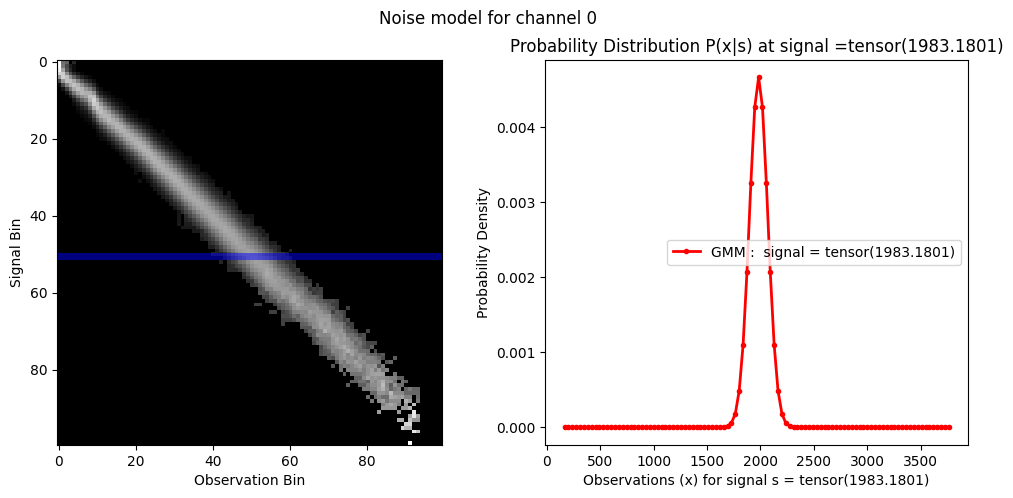

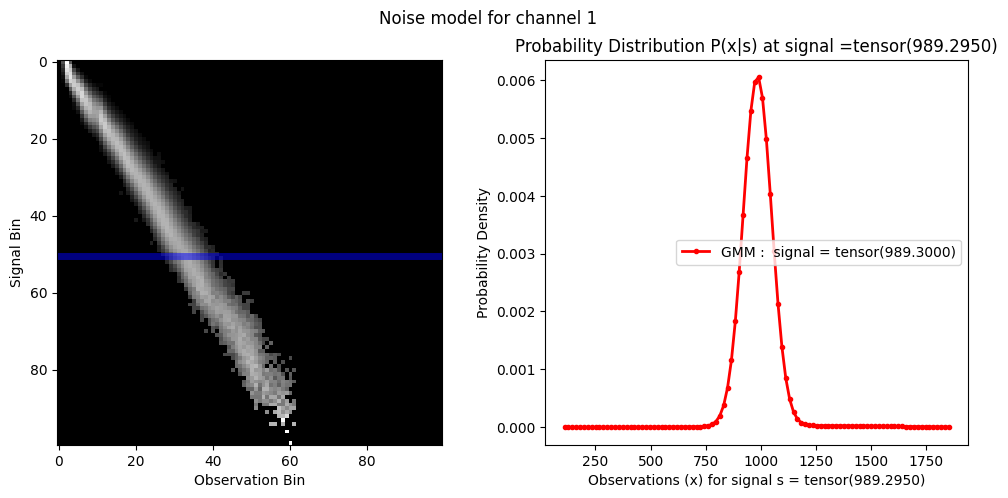

In [ ]:
for channel_idx in range(train_data.shape[-1]):

    # train Noise Model for current channel
    print(f"Training noise model for channel {channel_idx}")
    channel_data = train_data[..., channel_idx]
    channel_prediction = np.concatenate(prediction)[:, channel_idx]
    noise_model_config = GaussianMixtureNMConfig(
        model_type="GaussianMixtureNoiseModel",
        min_signal=channel_data.min(),
        max_signal=channel_data.max(),
        n_coeff=3,
        n_gaussian=3,
    )
    noise_model = GaussianMixtureNoiseModel(noise_model_config)
    noise_model.fit(signal=channel_data, observation=channel_prediction, n_epochs=5000)

    # save result on disk for later re-use
    noise_model.save(path=f"/group/jug/aman/Datasets/PAVIA_ATN/noise_models/", name=f"noise_model_Ch{channel_idx}")

    # show the result
    histogram = create_histogram(
        bins=100,
        min_val=channel_data.min(),
        max_val=channel_data.max(),
        signal=channel_data,
        observation=channel_prediction,
    )
    plot_probability_distribution(
        noise_model, signalBinIndex=50, histogram=histogram[0], channel=channel_idx
    )

### Once the cell above is ready you are done here! 👍